<a href="https://colab.research.google.com/github/jwjung1994/PyTorch/blob/main/GAN_tutorial_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b>GAN (Gnerative Adversarial Networks, NIPS 2014)</b>
학습 데이터셋: <b>MNIST</b> (1 X 28 X 28)

In [ ]:
import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

#### <b>생성자(Generator) 및 판별자(Discriminator) 모델 정의</b>

In [ ]:
latent_dim = 100

# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 하나의 블록(block) 정의
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                # 배치 정규화(batch normalization) 수행(차원 동일)
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # 생성자 모델은 연속적인 여러 개의 블록을 가짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

In [ ]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)

        return output

In [ ]:
# MNIST dataset Load
transforms_train = transforms.Compose([
    transforms.Resize(28),      #28 * 28
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for X, y in dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64


In [ ]:
print(len(dataloader))

469


#### <b>모델 학습 및 샘플링</b>

* 학습을 위해 생성자와 판별자 모델을 초기화합니다.
* 적절한 하이퍼 파라미터를 설정합니다.

In [ ]:
# 생성자(generator)와 판별자(discriminator) 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 손실 함수(loss function)
adversarial_loss = nn.BCELoss() #binary cross entropy
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

* 모델을 학습하면서 주기적으로 샘플링하여 결과를 확인할 수 있습니다.

In [ ]:
import time

n_epochs = 200 # 학습의 횟수(epoch) 설정
sample_interval = 2000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()

        """---------- 생성자(generator)를 학습 ----------"""
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """---------- 판별자(discriminator)를 학습 ----------"""
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)

        #
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        """----------------------------------------------------"""
        done = epoch * len(dataloader) + i #200 * 469 + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    if epoch % 10 == 0:
        print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 0/200] [D loss: 0.110650] [G loss: 2.998790] [Elapsed time: 13.21s]
[Epoch 10/200] [D loss: 0.272783] [G loss: 3.855502] [Elapsed time: 135.51s]
[Epoch 20/200] [D loss: 0.166788] [G loss: 5.930288] [Elapsed time: 257.88s]
[Epoch 30/200] [D loss: 0.098441] [G loss: 2.704642] [Elapsed time: 379.72s]
[Epoch 40/200] [D loss: 0.098244] [G loss: 3.240184] [Elapsed time: 501.47s]
[Epoch 50/200] [D loss: 0.123667] [G loss: 2.638002] [Elapsed time: 630.23s]
[Epoch 60/200] [D loss: 0.091776] [G loss: 3.867266] [Elapsed time: 754.23s]
[Epoch 70/200] [D loss: 0.190080] [G loss: 4.133970] [Elapsed time: 878.13s]
[Epoch 80/200] [D loss: 0.132558] [G loss: 3.283138] [Elapsed time: 1000.80s]
[Epoch 90/200] [D loss: 0.085611] [G loss: 3.436162] [Elapsed time: 1123.88s]
[Epoch 100/200] [D loss: 0.169244] [G loss: 3.190765] [Elapsed time: 1246.60s]
[Epoch 110/200] [D loss: 0.129977] [G loss: 3.486542] [Elapsed time: 1368.68s]
[Epoch 120/200] [D loss: 0.090994] [G loss: 3.184349] [Elapsed time: 149

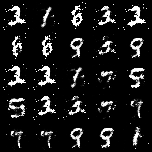

In [ ]:
from IPython.display import Image

Image('92000.png')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# save overall model
torch.save(generator, "/content/gdrive/My Drive/Colab Notebook/g_model.pt")

In [ ]:
# model save (only parameters)
torch.save(generator.state_dict(), "/content/gdrive/My Drive/Colab Notebook/g_params.pt")
print("Saved PyTorch Model State to g_params.pth")

Saved PyTorch Model State to generator.pth


In [ ]:
# model load
'''
model = generator()
model.load_state_dict(torch.load("generator.pth"))
'''